# Finetuning Nepali BERT model - Example

In [5]:
!nvidia-smi

Sat Nov  5 14:42:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 29%   33C    P8    10W / 270W |    181MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:04:00.0 Off |                  Off |
| 38%   

In [6]:
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['WANDB_DISABLED'] = 'true'

## Process the Dataset

### Locate and load different splits of our dataset with `datasets` module

In [7]:
from datasets import load_dataset

In [8]:
# Defining some constant values for our dataset
SIZE = '30K'
DATASET_ID = 'np20ng'

DATASET_PATH = '/home/suyogyat/research/dataset'
TRAIN_PATH = os.path.join(DATASET_PATH, DATASET_ID, f'{DATASET_ID}_{SIZE}_train.csv')
VALID_PATH = os.path.join(DATASET_PATH, DATASET_ID, f'{DATASET_ID}_{SIZE}_valid.csv')
TEST_PATH = os.path.join(DATASET_PATH, DATASET_ID, f'{DATASET_ID}_{SIZE}_test.csv') 

# Required to load dataset splits
data_files = {'train': TRAIN_PATH, 'valid': VALID_PATH, 'test': TEST_PATH}

dataset = load_dataset(path=DATASET_PATH, data_files=data_files)
print('Dataset: ', dataset)

Using custom data configuration dataset-98dd676346f734f0


Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 2006.20it/s]
0 tables [00:00, ? tables/s]/home/suyogyat/research/.RNN/lib/python3.8/site-packages/datasets/download/streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)
0 tables [00:00, ? tables/s]    /home/suyogyat/research/.RNN/lib/python3.8/site-packages/datasets/download/streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)
0 tables [00:00, ? tables/s]    /home/suyogyat/research/.RNN/lib/python3.8/site-packages/datasets/download/streaming_download_manager.py:714: Fut

Dataset csv downloaded and prepared to /home/suyogyat/.cache/huggingface/datasets/csv/dataset-98dd676346f734f0/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 177.82it/s]

Dataset:  DatasetDict({
    train: Dataset({
        features: ['source', 'category', 'heading', 'content', 'content_word_count', 'labels'],
        num_rows: 24000
    })
    valid: Dataset({
        features: ['source', 'category', 'heading', 'content', 'content_word_count', 'labels'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['source', 'category', 'heading', 'content', 'content_word_count', 'labels'],
        num_rows: 3000
    })
})


### Remove unwanted columns and label encode using `ClassLabel`

In [9]:
# Remove columns
dataset = dataset.remove_columns(['source', 'heading', 'content_word_count', 'labels'])

# Rename columns
dataset = dataset.rename_columns({'content': 'text', 'category': 'labels'})

# Label encode categorical column
dataset = dataset.class_encode_column('labels')

print('Dataset: ', dataset)

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset:  DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 24000
    })
    valid: Dataset({
        features: ['labels', 'text'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 3000
    })
})


In [10]:
dataset['train'].features

{'labels': ClassLabel(names=['Arts', 'Automobile', 'Bank', 'Business', 'Crime', 'Economy', 'Education', 'Employment', 'Entertainment', 'Health', 'Lifestyle', 'Literature', 'Market', 'Opinion', 'Politics', 'Society', 'Sports', 'Technology', 'Tourism', 'World'], id=None),
 'text': Value(dtype='string', id=None)}

In [11]:
def get_label2id_and_id2label():
    category_names = dataset['train'].features['labels'].names
    id2label = label2id = {}

    for i in range(0, len(category_names)):
        label2id[category_names[i]] = i

    id2label = {str(value):key for key, value in label2id.items()}

    return label2id, id2label

In [12]:
def get_num_labels():
    return dataset['train'].features['labels'].num_classes

## Load Model and Tokenizer

We will use Nepali BERT model **(Huggingface id: Rajan/NepaliBERT)** model and its respective tokenizer to tokenize our dataset.

In [13]:
# Some constants
MODEL_NAME = 'BERT'
MODEL_ID = 'Rajan/NepaliBERT'
TOKENIZER_ID = MODEL_ID
MAX_SEQ_LEN = 512

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

### Load the pretrained model using `MODEL_ID`

In [15]:
print(f'Loading {MODEL_NAME} model: {MODEL_ID}...')
label2id, id2label = get_label2id_and_id2label()
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, 
                                                            num_labels=get_num_labels(), 
                                                            label2id=label2id, 
                                                            id2label=id2label
                                                          )
print('Model loaded !')

Loading BERT model: Rajan/NepaliBERT...


Some weights of the model checkpoint at Rajan/NepaliBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rajan/NepaliBERT and are new

Model loaded !


### Load the pretrained tokenizer using `MODEL_ID`

The tokenizer ID is mostly same with the model ID.

In [16]:
print(f'Loading pretrained tokenizer: {MODEL_ID}...') 
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, 
                                            strip_accents=False, 
                                            clean_text=False
                                         )
print('Tokenizer loaded !')

Loading pretrained tokenizer: Rajan/NepaliBERT...
Tokenizer loaded !


Now, we tokenize our text data using the loaded tokenizer. We define a tokenization function, and this function will be mapped to all the text in our dataset. Additionally, after tokenizing, we will get **attention masks, token type ids** and **input ids** as additional columns which will be required to fine-tune the model. 

_**Note:** Only the Pytorch version of model is available at the Huggingface. So, we just have to add our tokenized dataset in the `torch` format._

In [17]:
# Function to apply on all the text data
def tokenize_function(data):
    """Tokenization method to apply collectively to all the samples.

    Parameters
    ----------
    data : DatasetDict
        Series of Text values.

    Returns
    -------
    tokenizer
        Tokenizer object with input ids, attention masks and token type ids.
    """
    return tokenizer(text=data['text'], 
                     truncation=True, 
                     padding=True, 
                     max_length=MAX_SEQ_LEN)

# Map our dataset using the defined tokeniz_function
tokenized_dataset = dataset.map(tokenize_function, batched=True, num_proc=4)

# Remove text column, as it is no longer required
tokenized_dataset = tokenized_dataset.remove_columns('text')

# Only torch format model is available
tokenized_dataset = tokenized_dataset.with_format('torch')

print('Tokenized dataset: ', tokenized_dataset)

#1:   0%|          | 0/6 [00:00<?, ?ba/s]

#2:   0%|          | 0/6 [00:00<?, ?ba/s]


#1:  17%|█▋        | 1/6 [00:04<00:23,  4.73s/ba]

#2:  17%|█▋        | 1/6 [00:05<00:25,  5.10s/ba]


#1:  33%|███▎      | 2/6 [00:09<00:19,  4.91s/ba]

#2:  33%|███▎      | 2/6 [00:09<00:19,  4.91s/ba]


#0:  50%|█████     | 3/6 [00:14<00:14,  4.72s/ba]

#1:  50%|█████     | 3/6 [00:15<00:15,  5.11s/ba]


#0:  67%|██████▋   | 4/6 [00:19<00:09,  4.73s/ba]

#2:  67%|██████▋   | 4/6 [00:19<00:09,  4.82s/ba]


#0:  83%|████████▎ | 5/6 [00:23<00:04,  4.65s/ba]

#1:  83%|████████▎ | 5/6 [00:24<00:04,  4.76s/ba]


#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]


#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]


#3:   0%|          | 0/1 [00:03<?, ?ba/s]


Tokenized dataset:  DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24000
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})


## Training Phase

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt

### Define Hyperparameters

In [19]:
LEARNING_RATE = 3e-05
EPOCHS = 10
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
WEIGHT_DECAY = 0.0

STEPS = 500    # Evaluation Steps, Logging Steps
EARLY_STOPPING_PATIENCE = 5    # Based on minimum validation loss
SAVE_TOTAL_LIMIT = 1    # Number of best model checkpoints to save

### Setup Training Arguments

In [20]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

In [21]:
training_args = TrainingArguments(output_dir='/home/suyogyat/research/models/',
                                  logging_dir='/home/suyogyat/research/models/',
                                  save_strategy='steps',
                                  evaluation_strategy='steps',
                                  num_train_epochs=EPOCHS,
                                  per_device_train_batch_size=TRAIN_BATCH_SIZE,
                                  per_device_eval_batch_size=EVAL_BATCH_SIZE, 
                                  learning_rate=LEARNING_RATE, 
                                  weight_decay=WEIGHT_DECAY,
                                  save_total_limit=SAVE_TOTAL_LIMIT,
                                  save_steps=STEPS,
                                  eval_steps=STEPS,
                                  logging_steps=STEPS,
                                  load_best_model_at_end=True,
                                  do_eval=True)
print('Training arguments loaded !')

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training arguments loaded !


### Setup Trainer

Here, we first define a function which will aid us to report classification metrics through our trainer.

Then, the trainer is setup using appropriate callbacks.

In [22]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    balanced_accuracy = balanced_accuracy_score(y_true=labels, y_pred=pred) 

    recall_weighted = recall_score(y_true=labels, y_pred=pred, average='weighted')    
    precision_weighted = precision_score(y_true=labels, y_pred=pred, average='weighted')    
    f1_weighted = f1_score(y_true=labels, y_pred=pred, average='weighted')

    recall_macro = recall_score(y_true=labels, y_pred=pred, average='macro')    
    precision_macro = precision_score(y_true=labels, y_pred=pred, average='macro')    
    f1_macro = f1_score(y_true=labels, y_pred=pred, average='macro')

    return {
        'accuracy': accuracy, 
        'balanced_accuracy': balanced_accuracy, 
        'precision_weighted': precision_weighted, 
        'recall_weighted': recall_weighted, 
        'f1_weighted':f1_weighted,
        'precision_macro': precision_macro, 
        'recall_macro': recall_macro, 
        'f1_macro': f1_macro
        }

# Define trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['valid'],
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
)

### Begin Training

In [23]:
trainer.train()

/home/suyogyat/research/.RNN/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 24000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7500
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Macro,Recall Macro,F1 Macro
500,1.133000,0.851771,0.726000,0.726000,0.737461,0.726000,0.719647,0.737461,0.726000,0.719647
1000,0.677400,0.702441,0.766000,0.766000,0.761879,0.766000,0.756683,0.761879,0.766000,0.756683
1500,0.545400,0.650770,0.786333,0.786333,0.784442,0.786333,0.782828,0.784442,0.786333,0.782828
2000,0.349900,0.676044,0.794667,0.794667,0.792845,0.794667,0.792045,0.792845,0.794667,0.792045
2500,0.267400,0.758259,0.787333,0.787333,0.787438,0.787333,0.784710,0.787438,0.787333,0.784710
3000,0.180000,0.799942,0.794333,0.794333,0.793814,0.794333,0.792831,0.793814,0.794333,0.792831
3500,0.085200,0.928481,0.791667,0.791667,0.786394,0.791667,0.786790,0.786394,0.791667,0.786790
4000,0.058000,1.034584,0.789000,0.789000,0.788432,0.789000,0.786205,0.788432,0.789000,0.786205


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to /home/suyogyat/research/models/checkpoint-500
Configuration saved in /home/suyogyat/research/models/checkpoint-500/config.json
Model weights saved in /home/suyogyat/research/models/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /home/suyogyat/research/models/checkpoint-500/tokenizer_config.json
Special tokens file saved in /home/suyogyat/research/models/checkpoint-500/special_tokens_map.json
Deleting older checkpoint [/home/suyogyat/research/models/checkpoint-1500] due to args.save_total_limit
Deleting older checkpoint [/home/suyogyat/research/models/checkpoint-4000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to /home/suyogyat/research/models/checkpoint-1000
Configuration saved in /home/suyogyat/research/models/checkpoint-1000/config.json
Model weights saved in /home/suyogyat/research/models/c

TrainOutput(global_step=4000, training_loss=0.41203406381607055, metrics={'train_runtime': 1995.7486, 'train_samples_per_second': 120.256, 'train_steps_per_second': 3.758, 'total_flos': 1.696126992384e+16, 'train_loss': 0.41203406381607055, 'epoch': 5.33})

## Testing Phase

In [24]:
def do_predictions():
    y_true = tokenized_dataset['test']['labels']
    print('y_true loaded from test dataset!')

    print('Starting predictions...')
    prediction_result = trainer.predict(tokenized_dataset['test'])
    raw_preds, _, test_metrics = prediction_result
    print('Predictions complete.')

    y_pred = [np.argmax(prediction) for prediction in raw_preds]
    print('y_pred added !')

    return y_true, y_pred, test_metrics, prediction_result

In [25]:
def show_confusion_matrix():
    data = {'y_true': y_true, 'y_pred': y_pred}
    df = pd.DataFrame(data, columns=['y_true', 'y_pred'])

    labels_to_category = {}
    for key, value in model.config.id2label.items():
        labels_to_category[int(key)] = value

    df.y_true = df.y_true.map(labels_to_category)
    df.y_pred = df.y_pred.map(labels_to_category)

    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual Category'], colnames=['Predicted Category'], margins=False)
    fig = plt.figure(figsize=(10, 10))

    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g')
    plt.title(f'{MODEL_ID}\nLR = {LEARNING_RATE}\nTest Accuracy = {round(test_metrics["test_accuracy"], 4)}\n')
    plt.show()

### Predict on Test Dataset

In [26]:
y_true, y_pred, test_metrics, prediction_result = do_predictions()

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


y_true loaded from test dataset!
Starting predictions...


Predictions complete.
y_pred added !


### Classification Report

In [27]:
print(classification_report(y_true, y_pred, target_names=model.config.label2id.keys()))

               precision    recall  f1-score   support

         Arts       0.66      0.83      0.74       150
   Automobile       0.79      0.95      0.87       150
         Bank       0.79      0.81      0.80       150
     Business       0.55      0.54      0.55       150
        Crime       0.81      0.93      0.86       150
      Economy       0.49      0.35      0.41       150
    Education       0.89      0.95      0.92       150
   Employment       0.85      0.87      0.86       150
Entertainment       0.93      0.71      0.81       150
       Health       0.86      0.75      0.80       150
    Lifestyle       0.87      0.88      0.87       150
   Literature       0.76      0.81      0.78       150
       Market       0.84      0.70      0.76       150
      Opinion       0.92      0.79      0.85       150
     Politics       0.88      0.79      0.83       150
      Society       0.63      0.59      0.61       150
       Sports       0.96      0.98      0.97       150
   Techno

### Confusion Matrix

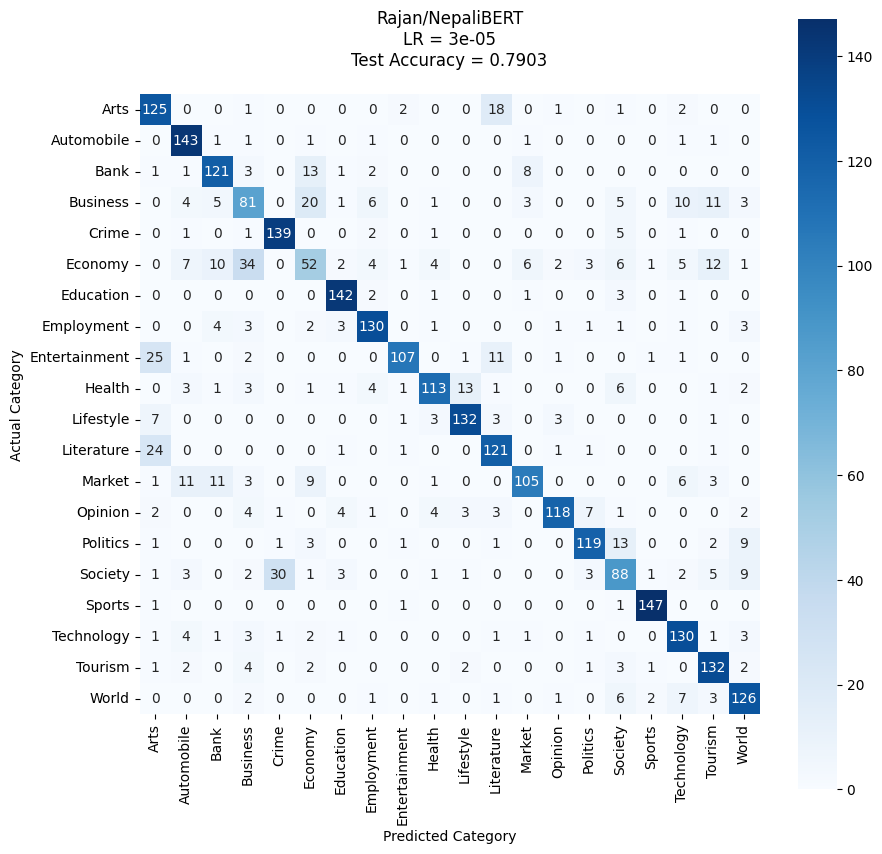

In [28]:
show_confusion_matrix()